# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from plot import plot_trajectory, plot_errors, plot_time_kinetic_energy
from plasma import cyclotron_xy, ExB_xy


In [2]:
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 15,
    "xtick.labelsize": 16,
    "ytick.labelsize": 15,
    "legend.fontsize": 13
})

# Boris Push and Main Loop

In [6]:

def null_E_field(x, t):
    return np.array([0.0, 0.0, 0.0])

def Ey0(x, t) :
    return np.array([0.0, 1.0, 0.0])

def Bz0(x, t):
    return np.array([0.0, 0.0, 1.0])

In [7]:

def boris_push(x, t, v, q, m, dt, electric_field, magnetic_field):
    """
    Advance velocity v by one full step using Boris scheme.
    x: position at half step (x_{n+1/2})
    t: time at half step (t_{n+1/2})
    v: velocity at time step n
    q, m: charge and mass
    dt: timestep
    """

    E = electric_field(x, t)
    B = magnetic_field(x, t)

    # Half acceleration by E
    v_minus = v + (q * dt / (2 * m)) * E

    # Rotation by B
    t_vec = (q * dt / (2 * m)) * B
    t_mag2 = np.dot(t_vec, t_vec)
    s_vec = 2 * t_vec / (1 + t_mag2)

    v_prime = v_minus + np.cross(v_minus, t_vec)
    v_plus = v_minus + np.cross(v_prime, s_vec)

    # Second half acceleration by E
    v_new = v_plus + (q * dt / (2 * m)) * E

    return v_new

In [8]:

def simulate(x0, v0, q, m, times, dt, electric_field, magnetic_field):
    """
    Simulate a particle trajectory using the Boris scheme.
    Returns arrays of x and v.
    """
    # Initializations
    x_half = x0 + 0.5 * dt * v0   # Leapfrog staggering
    v = v0.copy()

    # Storage
    xs = [x_half]
    vs = [v0]

    for i in range(len(times)-1) :
        # Velocity update (Boris)
        v = boris_push(x_half, times[i], v, q, m, dt, electric_field, magnetic_field)

        # Position update
        x_half = x_half + v * dt

        # Store
        xs.append(x_half.copy())
        vs.append(v.copy())

    return np.array(xs), np.array(vs)


# Plots

In [9]:
def plot_compare(x_num, vs_num, x_an, v_an, step=8, show_arrows=True, title='Numeric (scatter) vs Analytic (line) - xy projection', src="fig.pdf"):
    """
    Plot numeric scatter vs analytic curve (xy-projection), plus velocity arrows.
    x_num: numeric positions shape (N,3)
    vs_num: numeric velocities shape (N,3)
    x_an, v_an: analytic arrays of same shape
    step: sampling period for arrows
    """
    fig, ax = plt.subplots()

    # Numeric scatter
    ax.scatter(x_num[:,0], x_num[:,1], s=20, c='C0', label=r'$x_\mathrm{num}$')

    # Analytic curve
    ax.scatter(x_an[:,0], x_an[:,1], s=20, c='C1', label=r'$x_\mathrm{an}$')

    # initial points markers
    ax.scatter(x_num[0,0], x_num[0,1], marker='o', s=60, facecolors='none', edgecolors='k', label='start')

    if show_arrows:
        # numeric arrows (sampled)
        ax.quiver(
            x_num[::step,0], x_num[::step,1],
            vs_num[::step,0], vs_num[::step,1],
            angles='xy', scale_units='xy', scale=8, width=0.004,
            label=r'$v_{num}$', alpha=0.9
        )
        # analytic arrows (sampled, slightly shifted so they are visible)
        ax.quiver(
            x_an[::step,0], x_an[::step,1],
            v_an[::step,0], v_an[::step,1],
            angles='xy', scale_units='xy', scale=8, width=0.006,
            label=r'$v_\mathrm{an}$', alpha=0.6
        )

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    ax.set_title(title)
    plt.savefig(src, format="pdf", bbox_inches='tight')
    plt.show()
    
def plot_time_kinetic_energy(times, m, vs_num, src="fig.pdf") :
    v_norm = np.linalg.norm(vs_num, axis=1)
    Ek_x = 0.5 * m * vs_num[:,0]**2
    Ek_y = 0.5* m * vs_num[:,1]**2
    Ek_z = 0.5 * m * vs_num[:,2]**2
    Ek_tot = 0.5 * m * v_norm**2
    plt.figure(figsize=(6,4))
    plt.grid()
    plt.plot(times, Ek_x, label=r'$E_{k,x}$')
    plt.plot(times, Ek_y, label=r'$E_{k,y}$')
    plt.plot(times, Ek_z, label=r'$E_{k,z}$')
    plt.plot(times, Ek_tot, label=r"$E_{k, tot}$", color='black')
    plt.xlabel('time')
    plt.title('Kinetic energy vs time')
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
    plt.savefig(src, format="pdf", bbox_inches='tight')
    plt.show()

# Physical Parameters

In [10]:
q = -1.0
m = 1.0
B0 = 1.0

omega = q*B0/m
T=2*np.pi/abs(omega)
dt = 0.1
NT = 1
nsteps = int(NT*T/dt)
times = np.linspace(dt/2, nsteps*dt + dt/2, nsteps+1, endpoint=True)

x0 = np.array([1.0, 0.0,0.0])
v0 = np.array([0.0, 1.0, 0.0])

# Cyclotron Motion

In [11]:
x_cyc_num, v_cyc_num = simulate(x0, v0, q, m, times, dt, null_E_field, Bz0)
x_cyc_an, v_cyc_an = cyclotron_xy(x0, v0, q, m, 1.0, times, dt)

## Trajectories

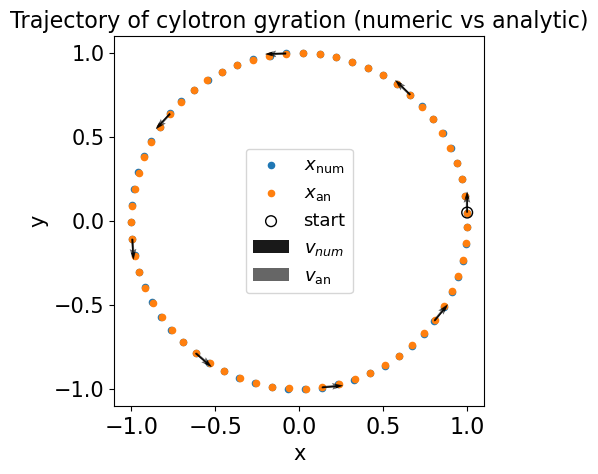

In [12]:
plot_compare(x_cyc_num, v_cyc_num, x_cyc_an, v_cyc_an, step=8, show_arrows=True, title="Trajectory of cylotron gyration (numeric vs analytic)", src="./img/traj_cyc.pdf")

## Kinetic energies

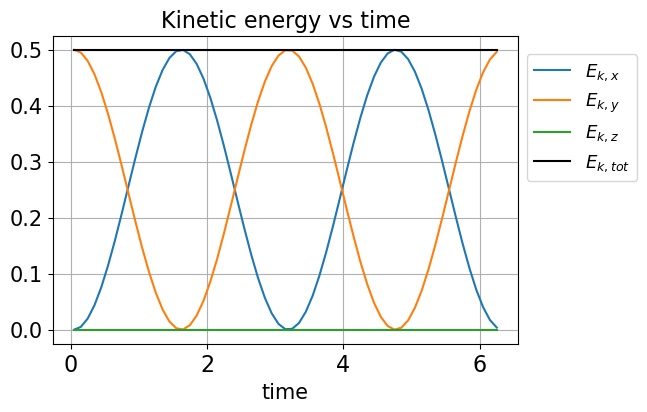

In [13]:
plot_time_kinetic_energy(times, m, v_cyc_num, src="./img/kin_cyc.pdf")

# ExB drift

In [14]:
x_ExB_num, v_ExB_num = simulate(x0, v0, q, m, times, dt, Ey0, Bz0)
x_ExB_an, v_ExB_an = ExB_xy(x0=x0, v0=v0, q=q, m=m, E=[0.0, 1.0, 0.0], B=[0.0, 0.0, 1.0], times=times, dt=dt)

## Trajectories

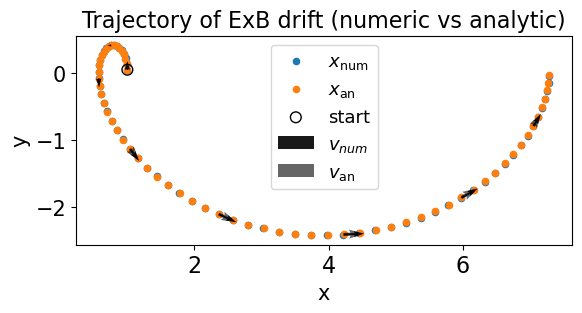

In [15]:
plot_compare(x_ExB_num, v_ExB_num, x_ExB_an, v_ExB_an, step=8, show_arrows=True, title="Trajectory of ExB drift (numeric vs analytic)", src="./img/traj_ExB.pdf")

# Errors

## Error in time

In [16]:
q = -1.0
m = 1.0
B0 = 1.0

omega = q*B0/m
T=2*np.pi/abs(omega)
dt = 0.1
NT = 10
nsteps = int(NT*T/dt)
times = np.linspace(dt/2, nsteps*dt + dt/2, nsteps+1, endpoint=True)

x0 = np.array([1.0, 0.0,0.0])
v0 = np.array([0.0, 1.0, 0.0])

x_cyc_num, v_cyc_num = simulate(x0, v0, q, m, times, dt, null_E_field, Bz0)
x_cyc_an, v_cyc_an = cyclotron_xy(x0, v0, q, m, 1.0, times, dt)
x_ExB_num, v_ExB_num = simulate(x0, v0, q, m, times, dt, Ey0, Bz0)
x_ExB_an, v_ExB_an = ExB_xy(x0=x0, v0=v0, q=q, m=m, E=[0.0, 1.0, 0.0], B=[0.0, 0.0, 1.0], times=times, dt=dt)

In [17]:
err_x_cyc = np.linalg.norm(x_cyc_num - x_cyc_an, axis=1)
err_x_ExB = np.linalg.norm(x_ExB_num - x_ExB_an, axis=1)

err_v_cyc = np.linalg.norm(v_cyc_num - v_cyc_an, axis=1)/np.linalg.norm(v_cyc_num, axis=1)
err_v_ExB = np.linalg.norm(v_ExB_num - v_ExB_an, axis=1)/np.linalg.norm(v_ExB_num, axis=1)

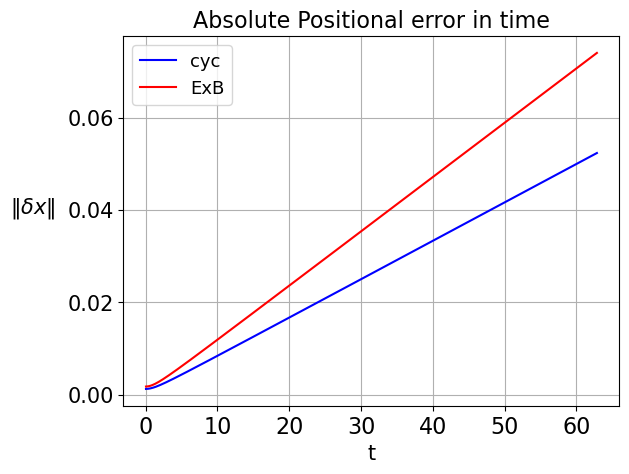

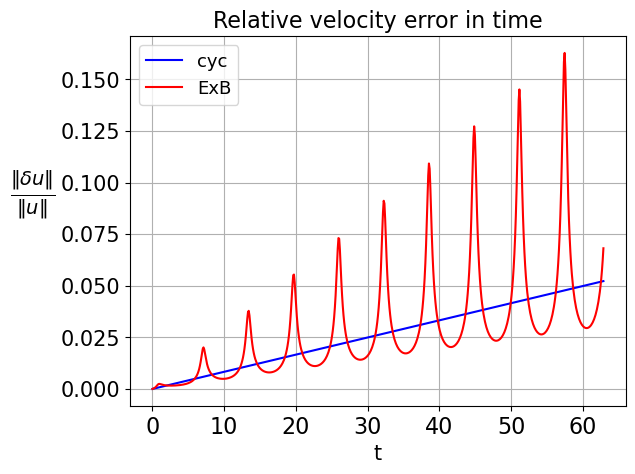

In [18]:
plt.figure()
plt.grid()
plt.plot(times, err_x_cyc, color='b', label='cyc')
plt.plot(times, err_x_ExB, color='r', label='ExB')
plt.xlabel('t')
plt.ylabel(r"$\|\delta x\|$", rotation=0, labelpad=25)
plt.title('Absolute Positional error in time')
plt.legend()
plt.savefig("./img/err_x.pdf", format="pdf", bbox_inches='tight')
plt.show()

plt.figure()
plt.grid()
plt.plot(times, err_v_cyc, color='b', label='cyc')
plt.plot(times,err_v_ExB, color='r', label='ExB')
plt.xlabel('t')
plt.ylabel(r"$\frac{\|\delta u\|}{\|u\|}$", rotation=0, fontsize=20, labelpad=20)
plt.title('Relative velocity error in time')
plt.legend()
plt.savefig("./img/err_v.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Error in time step

In [19]:
q = -1.0
m = 1.0
B0 = 1.0
omega = q*B0/m
T=2*np.pi/abs(omega)
NT = 6
x0 = np.array([1.0, 0.0,0.0])
v0 = np.array([0.0, 1.0, 0.0])

Dt = [np.pi/540, np.pi/180, np.pi/60, np.pi/20, np.pi/6]
err_x_cyc_dt = []
err_v_cyc_dt = []

err_x_ExB_dt = []
err_v_ExB_dt = []


for dt in Dt :

    nsteps = int(NT*T/dt)
    times = np.linspace(dt/2, nsteps*dt + dt/2, nsteps+1, endpoint=True)
    
    x_cyc_num, v_cyc_num = simulate(x0, v0, q, m, times, dt, null_E_field, Bz0)
    x_cyc_an, v_cyc_an = cyclotron_xy(x0, v0, q, m, 1.0, times, dt)

    diff_x_cyc = x_cyc_num - x_cyc_an
    x_cyc_norm_num = np.linalg.norm(x_cyc_num, axis=1)
    err_x_cyc = np.linalg.norm(diff_x_cyc, axis=1)
    err_x_cyc_dt.append(np.max(err_x_cyc))

    diff_v_cyc = v_cyc_num - v_cyc_an
    v_cyc_norm_num = np.linalg.norm(v_cyc_num, axis=1)
    err_v_cyc = np.linalg.norm(diff_v_cyc, axis=1)/v_cyc_norm_num
    err_v_cyc_dt.append(np.max(err_v_cyc))



    x_ExB_num, v_ExB_num = simulate(x0, v0, q, m, times, dt, Ey0, Bz0)
    x_ExB_an, v_ExB_an = ExB_xy(x0=x0, v0=v0, q=q, m=m, E=[0.0, 1.0, 0.0], B=[0.0, 0.0, 1.0], times=times, dt=dt)

    diff_x_ExB = (x_ExB_num - x_ExB_an)
    err_x_ExB = np.linalg.norm(diff_x_ExB, axis=1)
    err_x_ExB_dt.append(np.max(err_x_ExB))

    diff_v_ExB = v_ExB_num - v_ExB_an
    v_ExB_norm_num = np.linalg.norm(v_ExB_num, axis=1)
    err_v_ExB = np.linalg.norm(diff_v_ExB, axis=1)/v_ExB_norm_num
    err_v_ExB_dt.append(np.max(err_v_ExB))

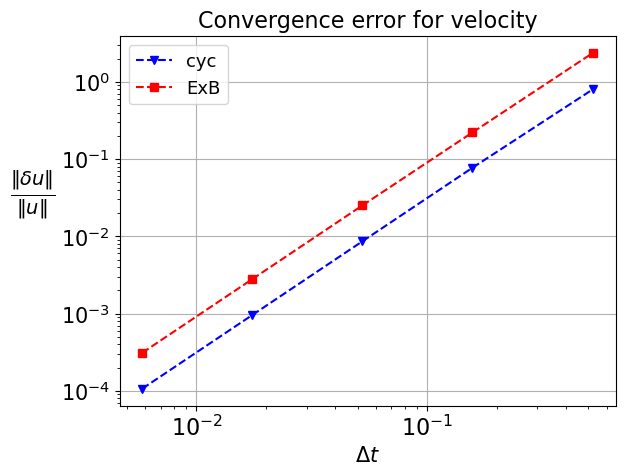

In [20]:
plt.figure()
plt.grid()
plt.xlabel(r"$\Delta t$")
plt.ylabel(r"$\frac{\|\delta u\|}{\|u\|}$", rotation=0, fontsize=20, labelpad=20)
plt.title("Convergence error for velocity")
plt.loglog(Dt, err_v_cyc_dt, 'v--', color='b', label='cyc')
plt.loglog(Dt, err_v_ExB_dt, 's--', color='r', label='ExB')
plt.legend()
plt.savefig("./img/conv_err_v.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Magnetic Bottle

## uniform z-axis Helmotlz coil

In [21]:
def Bcoil(z,R, B0):
    Bfield = B0*(1+(z/R)**2)**(-3./2.)
    return Bfield


def BHelmholtz(z,R, B0):
    Bfield = Bcoil(z+R, R, B0)+Bcoil(z-R, R, B0)
    return Bfield

def BHelmoltz_r(z,R, B0):
    Bfield = (B0/np.sqrt(2.))*(1 + (9./4.)*(z/R)**2)
    return Bfield

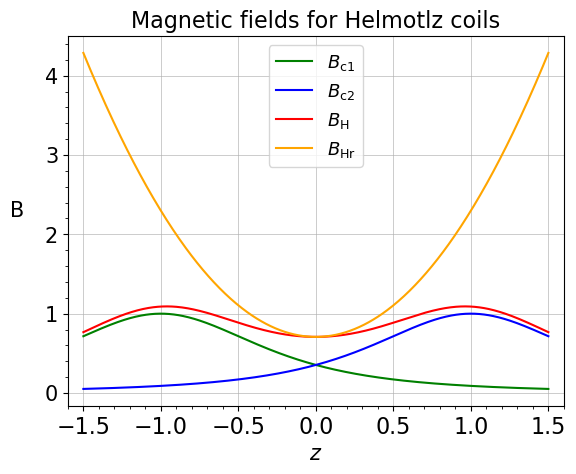

In [22]:
z=np.linspace(-1.5,1.5,500)
R=1
B0 = 1

fig, ax2 = plt.subplots()
ax2.minorticks_on()
ax2.plot(z, Bcoil(z+R,R, B0),'g', label=r'$B_\mathrm{c1}$')
ax2.plot(z, Bcoil(z-R,R, B0),'b', label=r'$B_\mathrm{c2}$')
ax2.plot(z, BHelmholtz(z,R, B0),'r', label=r'$B_\mathrm{H}$')
ax2.plot(z, BHelmoltz_r(z,R, B0), color='orange', label=r'$B_\mathrm{Hr}$')
ax2.set_xlim(-1.6, 1.6)
ax2.set_xlabel(r"$z$")
ax2.set_ylabel(r"B", rotation=0, labelpad=20)
ax2.grid(linewidth=0.45)
ax2.set_title("Magnetic fields for Helmotlz coils")
plt.legend()
plt.show()

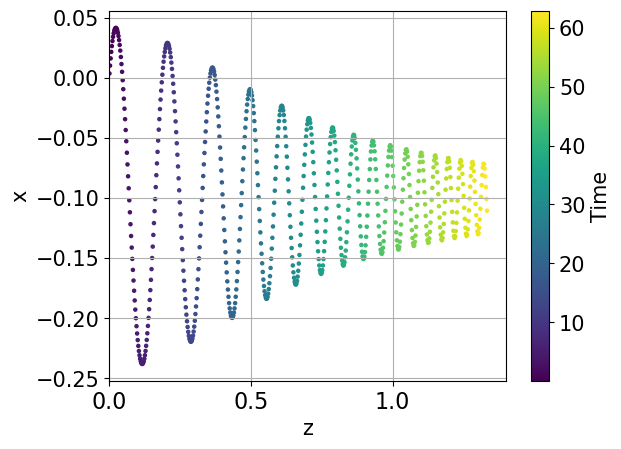

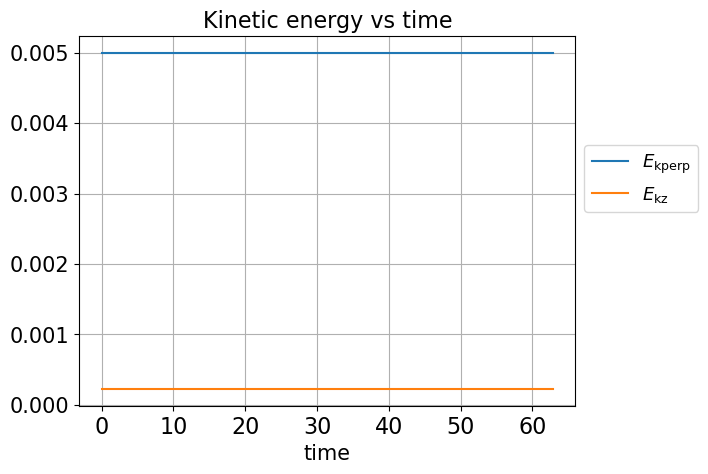

In [23]:
def BHr(x, t):
    return np.array([0.0, 0.0, BHelmoltz_r(x[2], R, B0)])

q = -1.0
m = 1.0
B0 = 1.0
R = 1.0

omega = q*B0/m
T=2*np.pi/abs(omega)
dt = 0.1
NT = 10
nsteps = int(NT*T/dt)
times = np.linspace(dt/2, nsteps*dt + dt/2, nsteps+1, endpoint=True)

x0 = np.array([0.0, 0.0,0.0])
v0 = np.array([np.sqrt(2.)/20., np.sqrt(2.)/20, 3.*np.sqrt(2.)/200])

x_num, v_num = simulate(x0, v0, q, m, times, dt, null_E_field, BHr)

plt.figure()
plt.scatter(x_num[:,2], x_num[:,0], c=times, cmap='viridis', s=5)
plt.colorbar(label='Time')
plt.xlabel('z')
plt.ylabel('x')
plt.xlim(0, 1.4)
plt.grid()
plt.show()

Ek_x = 0.5 * m * v_num[:,0]**2
Ek_y = 0.5 * m * v_num[:,1]**2
Ek_perp = Ek_x + Ek_y
Ek_z = 0.5 * m * v_num[:,2]**2
plt.figure()
plt.grid()
plt.plot(times, Ek_perp, label=r'$E_\mathrm{kperp}$')
plt.plot(times, Ek_z, label=r'$E_\mathrm{kz}$')
plt.xlabel('time')
plt.title('Kinetic energy vs time')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

## Full configuration Helmholtz coil

In [24]:
def polygon(sides, radius=1, rotation=0, translation=None):
    one_segment = 2*math.pi/sides
    points = [(math.sin(i*one_segment + rotation)*radius, 0, math.cos(i*one_segment + rotation)*radius) for i in range(sides)]
    if translation:
        points = [[sum(pair) for pair in zip(point, translation)] for point in points]
    return points


def pointB(x,y,z,wire, B0):
    xA, yA, zA = wire[0][0], wire[0][1], wire[0][2]
    xB, yB, zB = wire[1][0], wire[1][1], wire[1][2]
    r1    =  np.sqrt((x-xA)**2+(y-yA)**2+(z-zA)**2)
    r2    =  np.sqrt((x-xB)**2+(y-yB)**2+(z-zB)**2)
    L     =  np.sqrt((xB-xA)**2+(yB-yA)**2+(zB-zA)**2)
    CosTheta1 = (r2**2 - r1**2 - L**2)/(2*L*r1)
    CosTheta2 = (r2**2 - r1**2 + L**2)/(2*L*r2)
    distance  = np.sqrt(2*r1**2*r2**2+2*r1**2*L**2+2*r2**2*L**2-r1**4-r2**4-L**4)/(2*L)
    Bfield    = B0*(CosTheta2 - CosTheta1)/distance
    return Bfield


def Bvector(x,y,z,wire, B0):
    xA, yA, zA = wire[0][0], wire[0][1], wire[0][2]
    xB, yB, zB = wire[1][0], wire[1][1], wire[1][2]
    Bfield = pointB(x,y,z, wire, B0)
    vx = (yB-yA)*(z-zA)  - (y-yA)*(zB-zA)
    vy = (x-xA) *(zB-zA) - (xB-xA)*(z-zA)
    vz = (xB-xA)*(y-yA)  - (x-xA)*(yB-yA)
    v  = np.sqrt(vx**2+vy**2+vz**2)
    Bx = Bfield*vx/v
    By = Bfield*vy/v
    Bz = Bfield*vz/v
    return Bx,By,Bz

In [25]:
q = -1.0
m = 1.0
B0 = 1.0

radius    = 1
Nsegments = 100

circle1=polygon(Nsegments, radius, 0, [0., -1, 0.])
circle1.append(circle1[0])

circle2=polygon(Nsegments, radius, 0, [0., 1, 0.])
circle2.append(circle2[0])


def BH(x, t) :
    Bx,By,Bz=0,0,0
    counter=0
    for i in range(len(circle1)-1):
        BX,BY,BZ = Bvector(x[0],x[1],x[2], [circle1[counter],circle1[counter+1]], B0/6)
        BX2,BY2,BZ2 = Bvector(x[0],x[1],x[2], [circle2[counter],circle2[counter+1]], B0/6)
        Bx += BX+BX2
        By += BY+BY2
        Bz += BZ+BZ2
        counter+=1
    return np.array([Bx, By, Bz])

In [26]:
I = 1000  # electric current
N = 50    # define a grid of N^3 points  
x = np.linspace(-1, 2, N)  # spatial points in x 
y = np.linspace(-1, 2, N)  # spatial points in y 
z = np.linspace(-1, 2, N)  # spatial points in z 
x, y, z = np.meshgrid(x, y, z)  # meshgrid
zplane  = int(round(N/2))  # define z=0 plane

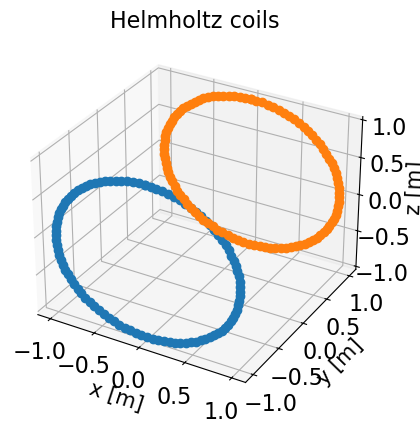

In [27]:
# Plot geometry of the system
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Helmholtz coils')

ax.plot(np.array(circle1)[:,0],np.array(circle1)[:,1],np.array(circle1)[:,2],'-o')
ax.plot(np.array(circle2)[:,0],np.array(circle2)[:,1],np.array(circle2)[:,2],'-o')

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.show()
fig.clear()

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# --- define the plane grid ---
N = 100                      # grid resolution
xvals = np.linspace(-2, 2, N)
yvals = np.linspace(-2, 2, N)

X, Y = np.meshgrid(xvals, yvals)
Z = np.zeros_like(X)        # z = 0 plane

# --- compute magnetic field at each point ---
BX = np.zeros_like(X)
BY = np.zeros_like(Y)
BZ = np.zeros_like(Z)

for i in range(N):
    for j in range(N):
        B = BH([X[i,j], Y[i,j], Z[i,j]])
        BX[i,j], BY[i,j], BZ[i,j] = B

# --- compute magnitude ---
Bmag = np.sqrt(BX**2 + BY**2 + BZ**2)

# --- plot ---
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

# color background = field magnitude
im = ax.pcolormesh(X, Y, np.log10(Bmag), shading='auto', cmap='jet')

# streamlines = field direction
ax.streamplot(X, Y, BX, BY, color='k', density=1.0, linewidth=0.8)

# optionally: draw the coil positions if you have them
circle1_xy = np.array([[p[0], p[1]] for p in circle1])
circle2_xy = np.array([[p[0], p[1]] for p in circle2])
ax.plot(circle1_xy[:,0], circle1_xy[:,1], 'r-', lw=1.5, label='Coil 1')
ax.plot(circle2_xy[:,0], circle2_xy[:,1], 'b-', lw=1.5, label='Coil 2')

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.legend()
fig.colorbar(im, ax=ax, label='log10(|B|)')
plt.tight_layout()
plt.show()


TypeError: BH() missing 1 required positional argument: 't'

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# --- define axis points ---
yvals = np.linspace(-2, 2, 200)   # adjust to your coil spacing and scale
Bmag = np.zeros_like(yvals)

# --- compute B at each point (x=0, z=0) ---
for i, y in enumerate(yvals):
    B = BH([0, y, 0])             # evaluate your BH(x) function
    Bmag[i] = np.linalg.norm(B)   # compute magnitude

# --- plot ---
plt.figure(figsize=(6,4))
plt.plot(yvals, Bmag, 'r-', lw=2)
plt.xlabel('y [m]')
plt.ylabel('|B| [T]')
plt.title('Magnetic field magnitude along Helmholtz axis (x=0, z=0)')
plt.grid(True)
plt.tight_layout()
plt.show()

TypeError: BH() missing 1 required positional argument: 't'

In [30]:
N = 100
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
z = np.linspace(-2, 2, N)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')


BX = np.zeros_like(X)
BY = np.zeros_like(Y)
BZ = np.zeros_like(Z)

for i in range(N):
    for j in range(N):
        B = BH([X[i,j], Y[i,j], Z[i,j]])
        BX[i,j], BY[i,j], BZ[i,j] = B

TypeError: BH() missing 1 required positional argument: 't'

/tmp/ipykernel_18661/1012169078.py:11: RuntimeWarning: invalid value encountered in divide
  gradB_over_B = gradB_mag / Bmag
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


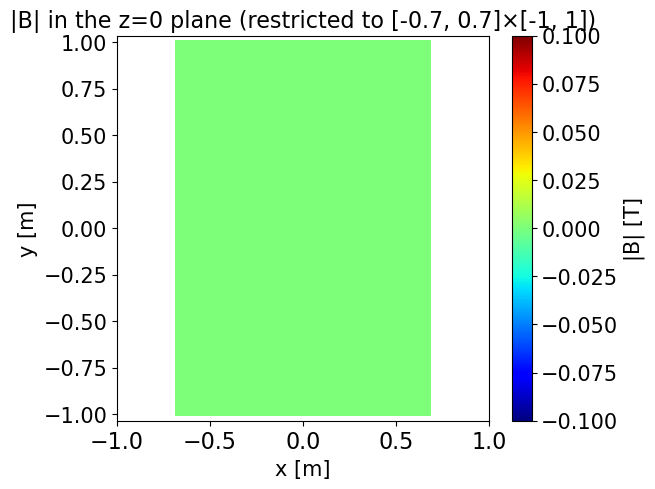

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


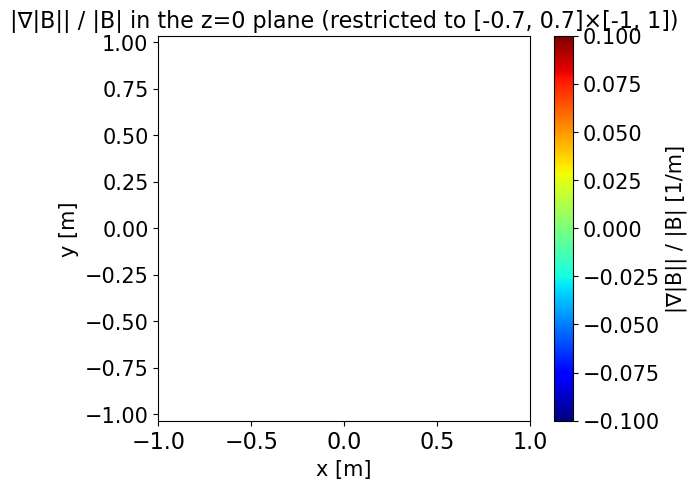

In [31]:
Bmag = np.sqrt(BX**2 + BY**2 + BZ**2)

dX = X[1,0,0] - X[0,0,0]
dY = Y[0,1,0] - Y[0,0,0]
dZ = Z[0,0,1] - Z[0,0,0]

dBmag_dx, dBmag_dy, dBmag_dz = np.gradient(Bmag, dX, dY, dZ)

# scalar form
gradB_mag = np.sqrt(dBmag_dx**2 + dBmag_dy**2 + dBmag_dz**2)
gradB_over_B = gradB_mag / Bmag


zplane = N // 2

mask_x = (x >= -0.7) & (x <= 0.7)
mask_y = (y >= -1) & (y <= 1)

# extract the subregion
Xsub = X[mask_x][:, mask_y, zplane]
Ysub = Y[mask_x][:, mask_y, zplane]
gradB_over_B_sub = gradB_over_B[mask_x][:, mask_y, zplane]
Bmag_sub = Bmag[mask_x][:, mask_y, zplane]

plt.figure(figsize=(6,5))
plt.title('|B| in the z=0 plane (restricted to [-0.7, 0.7]×[-1, 1])')
plt.pcolormesh(Xsub, Ysub, Bmag_sub, shading='auto', cmap='jet')
plt.colorbar(label='|B| [T]')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

plt.figure(figsize=(6,5))
plt.title('|∇|B|| / |B| in the z=0 plane (restricted to [-0.7, 0.7]×[-1, 1])')
plt.pcolormesh(Xsub, Ysub, gradB_over_B_sub, shading='auto', cmap='jet')
plt.colorbar(label='|∇|B|| / |B| [1/m]')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [45]:
q = -1.0
m = 1.0
B0 = 1.0
R = 1.0

omega = q*B0/m
T=2*np.pi/abs(omega)
dt = 0.1
NT = 300
nsteps = int(NT*T/dt)
times = np.linspace(dt/2, nsteps*dt + dt/2, nsteps+1, endpoint=True)

x0 = np.array([0.0, 0.0, 0.0])
v0 = np.array([0.05/np.sqrt(2), 0.05/np.sqrt(2), 0.05/np.sqrt(2)])

x_num, v_num = simulate(x0, v0, q, m, times, dt, null_E_field, BH)

In [50]:
Bvec = []
for i in range(len(x_num[:,1])) :
    x = x_num[i,:]
    t = times[i]
    B = BH(x, t)
    Bvec.append(B)
Bvec = np.array(Bvec)
Bnorm = np.linalg.norm(Bvec, axis=1)


#find mirrored indexed
indexes_bound=np.where(v_num[:-1,1]*v_num[1:,1]<0)[0]

#compute second adiabatic invariant
J=np.zeros((len(times)))

J[:indexes_bound[0]]=np.nan
J[indexes_bound[-1]:]=np.nan
for j in range(len(indexes_bound)-1):
    dz=np.linalg.norm(x_num[indexes_bound[j]+1:indexes_bound[j+1]+1,:]-x_num[indexes_bound[j]:indexes_bound[j+1],:])
    J[indexes_bound[j]:indexes_bound[j+1]]=np.abs(np.sum(v_num[indexes_bound[j]:indexes_bound[j+1],2]*dz))


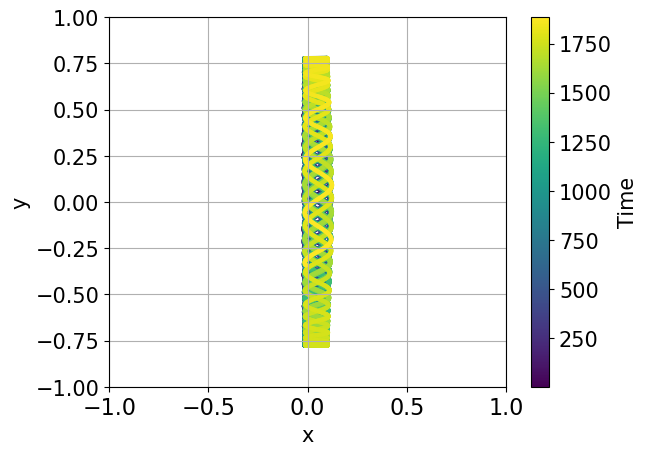

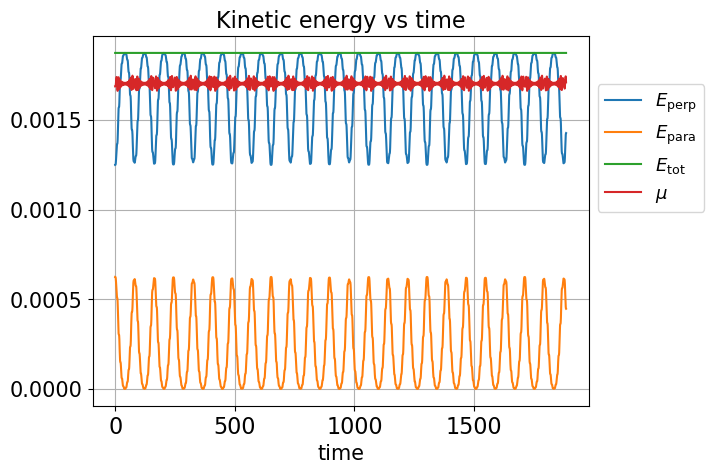

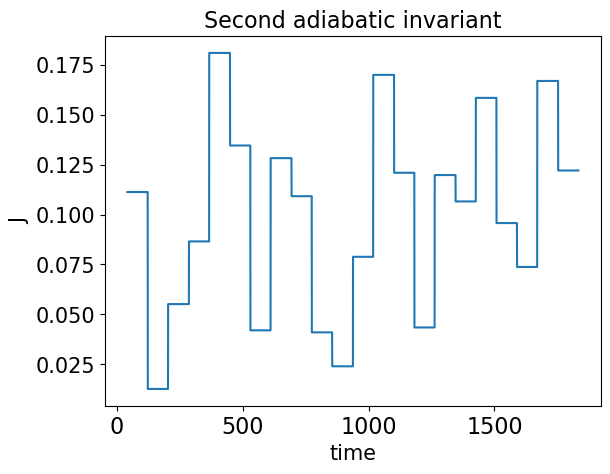

In [51]:
plt.figure()
plt.scatter(x_num[:,0], x_num[:,1], c=times, cmap='viridis', s=5)
plt.colorbar(label='Time')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid()
plt.show()

E_perp =  0.5 * m * (v_num[:,0]**2 + v_num[:,2]**2)
E_para = 0.5 * m * v_num[:,1]**2
E_tot = E_perp + E_para

mu = E_perp/Bnorm

plt.figure()
plt.grid()
plt.plot(times, E_perp, label=r'$E_\mathrm{perp}$')
plt.plot(times, E_para, label=r'$E_\mathrm{para}$')
plt.plot(times, E_tot, label=r'$E_\mathrm{tot}$')
plt.plot(times, mu, label=r'$\mu$')
plt.xlabel('time')
plt.title('Kinetic energy vs time')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))


plt.figure()
plt.plot(times,J,label=r'$J$')
plt.xlabel("time")
plt.ylabel("J")
plt.title("Second adiabatic invariant")
plt.show()

Confinement Cone

In [53]:
from numba import jit

def plot_trajectory_mirror(xs_num,t):
    fig=plt.figure()
    ax = fig.add_subplot(projection='3d')
    # ax.scatter(xs_num[:,2], xs_num[:,1], xs_num[:,0], c=t, cmap='viridis', s=5)  # s controls point size
    ax.scatter(xs_num[:,2], xs_num[:,1], xs_num[:,0], c=t, cmap='viridis', s=5)  # s controls point size
    # plt.colorbar(label='Time')
    ax.set_xlabel('z')
    ax.set_ylabel('y')
    # ax.set_xlim(-2000,2000)
    ax.grid()
    plt.show()

@jit
def null_E_field(x, t):
    return np.zeros((3))

@jit
def polygon(sides, radius=1, rotation=0, translation=None):
    one_segment = 2*math.pi/sides
    points=np.zeros((sides+1,3))
    for i in range(sides):
        points[i,0]=math.sin(i*one_segment + rotation)*radius
        points[i,1]=0
        points[i,2]=math.cos(i*one_segment + rotation)*radius
    points[sides,0]=points[0,0]
    points[sides,1]=points[0,1]
    points[sides,2]=points[0,2]
    # points = [(math.sin(i*one_segment + rotation)*radius, 0, math.cos(i*one_segment + rotation)*radius) for i in range(sides)]
    if translation is not None:
        for i in range(points.shape[0]):
            points[i,:] += translation
        # points = np.array([[sum(pair) for pair in zip(point, translation)] for point in points])
    return points

@jit
def pointB(x,y,z,wire, B0):
    xA, yA, zA = wire[0,0], wire[0,1], wire[0,2]
    xB, yB, zB = wire[1,0], wire[1,1], wire[1,2]
    r1    =  np.sqrt((x-xA)**2+(y-yA)**2+(z-zA)**2)
    r2    =  np.sqrt((x-xB)**2+(y-yB)**2+(z-zB)**2)
    L     =  np.sqrt((xB-xA)**2+(yB-yA)**2+(zB-zA)**2)
    CosTheta1 = (r2**2 - r1**2 - L**2)/(2*L*r1)
    CosTheta2 = (r2**2 - r1**2 + L**2)/(2*L*r2)
    distance  = np.sqrt(2*r1**2*r2**2+2*r1**2*L**2+2*r2**2*L**2-r1**4-r2**4-L**4)/(2*L)
    Bfield    = B0*(CosTheta2 - CosTheta1)/distance
    return Bfield

@jit
def Bvector(x,y,z,wire, B0):
    xA, yA, zA = wire[0,0], wire[0,1], wire[0,2]
    xB, yB, zB = wire[1,0], wire[1,1], wire[1,2]
    Bfield = pointB(x,y,z, wire, B0)
    vx = (yB-yA)*(z-zA)  - (y-yA)*(zB-zA)
    vy = (x-xA) *(zB-zA) - (xB-xA)*(z-zA)
    vz = (xB-xA)*(y-yA)  - (x-xA)*(yB-yA)
    v  = np.sqrt(vx**2+vy**2+vz**2)
    Bx = Bfield*vx/v
    By = Bfield*vy/v
    Bz = Bfield*vz/v
    return Bx,By,Bz

@jit
def BH(x, t) :
    Bx,By,Bz=0,0,0
    counter=0
    wire=np.zeros((2,3))
    for i in range(circle1.shape[0]-1):
        wire[0,:]=circle1[counter,:]
        wire[1,:]=circle1[counter+1,:]
        BX,BY,BZ = Bvector(x[0],x[1],x[2], wire, B0/6)
        wire[0,:]=circle2[counter,:]
        wire[1,:]=circle2[counter+1,:]
        BX2,BY2,BZ2 = Bvector(x[0],x[1],x[2], wire, B0/6)
        Bx += BX+BX2
        By += BY+BY2
        Bz += BZ+BZ2
        counter+=1
    B=np.zeros((3))
    B[0]=Bx
    B[1]=By
    B[2]=Bz
    return B

@jit
def trapped_time(xs_num):
    k=0
    while np.any(np.abs(xs_num[k,:])<3) and k<xs_num.shape[0]-1:
        k+=1
    return k

@jit

def boris_push(x, t, v, q, m, dt):
    """
    Advance velocity v by one full step using Boris scheme.
    x: position at half step (x_{n+1/2})
    t: time at half step (t_{n+1/2})
    v: velocity at time step n
    q, m: charge and mass
    dt: timestep
    """

    E = null_E_field(x, t)
    B = BH(x, t)
    # print(B)

    # Half acceleration by E
    v_minus = v + (q * dt / (2 * m)) * E

    # Rotation by B
    t_vec = (q * dt / (2 * m)) * B
    t_mag2 = np.dot(t_vec, t_vec)
    s_vec = 2 * t_vec / (1 + t_mag2)

    v_prime = v_minus + np.cross(v_minus, t_vec)
    v_plus = v_minus + np.cross(v_prime, s_vec)

    # Second half acceleration by E
    v_new = v_plus + (q * dt / (2 * m)) * E

    return v_new,B

@jit
def simulate(x0, v0, q, m, dt, nsteps):
    """
    Simulate a particle trajectory using the Boris scheme.
    Returns arrays of x and v.
    """
    # Initializations
    x_half = x0 + 0.5 * dt * v0   # Leapfrog staggering
    v = v0.copy()

    # Storage
    # xs = [x_half]
    # vs = [v0]
    xs=np.zeros((nsteps+1,3))
    vs=np.zeros((nsteps+1,3))

    for n in range(nsteps):
        # Velocity update (Boris)
        v,B = boris_push(x_half, (n + 1/2) * dt, v, q, m, dt)

        # Position update
        x_half = x_half + v * dt

        # Store
        # xs.append(x_half.copy())
        # vs.append(v.copy())
        xs[n+1,:] = x_half.copy()
        vs[n+1,:] = v.copy()

    return xs, vs,B

@jit
def multi_vpar_simulation(Nv,v0_list,x0,q,m,dt,nsteps):
    # print(Nv,nsteps)
    xs_num_array=np.zeros((Nv,nsteps+1,3))
    t_trapped_array=np.zeros((Nv))
    vs_num_array=np.zeros((Nv,nsteps+1,3))
    B_num_array=np.zeros((Nv,nsteps+1,3))


    for i in range(Nv):
        v0=v0_list[i]    

        # NumericalS trajectory
        x_num, v_num,B= simulate(x0, v0, q, m, dt, nsteps)
        xs_num_array[i,:,:]=x_num
        vs_num_array[i,:,:]=v_num
        t_trapped_array[i]=trapped_time(x_num)
        B_num_array[i,:,:]=B
        # plot_trajectory_mirror(x_num,t)
    return xs_num_array,vs_num_array,t_trapped_array,B_num_array

In [61]:
q = -1.0
m = 1.0
B0 = 1.0
R = 1.0


radius    = 1
Nsegments = 100

circle1=polygon(Nsegments, radius, 0, np.array([0., -1, 0.]))
# circle1.append(circle1[0])

circle2=polygon(Nsegments, radius, 0, np.array([0., 1, 0.]))
# circle2.append(circle2[0])

omega = q*B0/m
T=2*np.pi/abs(omega)
dt = 0.1
NT = 500
nsteps = int(NT*T/dt)
times = np.linspace(dt/2, nsteps*dt + dt/2, nsteps+1, endpoint=True)

x0 = np.array([0.0, 0.0, 0.0])
# v0 = np.array([0.05/np.sqrt(2), 0.05/np.sqrt(2), 0.05/np.sqrt(2)])

#Simulation for different parallel velocities
Nv=100
v_par=np.linspace(0,10000,Nv)
v0_list=[np.array([0.05/np.sqrt(2), 0.05/np.sqrt(2),0.05/np.sqrt(2)+0.0001*j]) for j in v_par]
theta_cone=np.array([np.arccos(np.dot(v0,np.array([0.0,1.0,0.0]))/np.linalg.norm(v0)) for v0 in v0_list])

xs_num_list,vs_num_list,t_trapped_list,B_num_list=multi_vpar_simulation(Nv,v0_list,x0,q,m,dt,nsteps)

t_trapped_list=np.array(t_trapped_list)
# print(t_trapped_list)



#compute Bm from simu for theta cone simu
Bm_list=np.zeros((xs_num_list.shape[0]))
index_freed=[]
index_trapped=[]
bounces_number=np.zeros((xs_num_list.shape[0]))
for i in range(xs_num_list.shape[0]):
    if np.any(np.abs(xs_num_list[i,-1,:])<3):
        index_trapped.append(i)
        indexes_bound=np.where(vs_num_list[i,:-1,1]*vs_num_list[i,1:,1]<0)[0]
        bounces_number[i]=len(indexes_bound)
        if len(indexes_bound)==0:
            Bm_list[i]=np.nan
            
        else:
            B=BH(xs_num_list[i,indexes_bound[0],:], times[indexes_bound[0]])
            Bm_list[i]=np.linalg.norm(B)
    else:
        index_freed.append(i)
        Bm_list[i]=np.nan

        # print(indexes,xs_num_list[i,indexes[0],:])
B0=np.linalg.norm(BH(np.array([0,0,0]),0))
theta_cone_simu=np.arcsin(np.sqrt(B0/Bm_list))
Bm_ana=B0/(np.sin(theta_cone)**2)
Bm_ana[index_freed]=np.nan

#compute 2nd adiabatic invariant for bounded particles
J=[]
J_mean=np.zeros((xs_num_list.shape[0]))
for i in range(xs_num_list.shape[0]):
    if i in index_trapped:
        indexes_bound=np.where(vs_num_list[i,:-1,1]*vs_num_list[i,1:,1]<0)[0]
        for j in range(len(indexes_bound)-1):
            dz=np.linalg.norm(xs_num_list[i,indexes_bound[j]+1:indexes_bound[j+1]+1,:]-xs_num_list[i,indexes_bound[j]:indexes_bound[j+1],:])
            J.append(np.sum(vs_num_list[i,indexes_bound[j]:indexes_bound[j+1],2]*dz))
        J_mean[i]=np.mean(J)
    else:
        J_mean[i]=np.nan




# for i in range(Nv):
#     print(Bm_ana[i],Bm_list[i],theta_cone[i]*180/np.pi)
#     plot_trajectory_mirror(xs_num_list[i],times)

/tmp/ipykernel_18661/177243189.py:61: RuntimeWarning: invalid value encountered in arcsin
  theta_cone_simu=np.arcsin(np.sqrt(B0/Bm_list))


/tmp/ipykernel_18661/3798972941.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


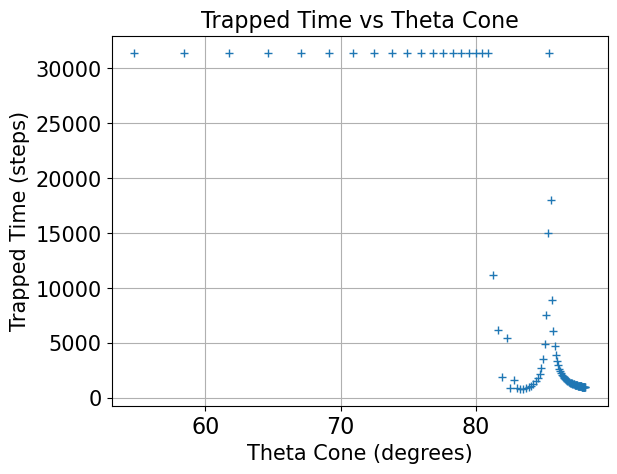

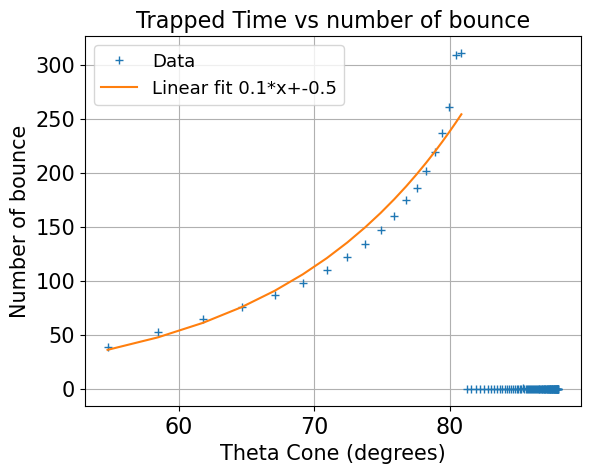

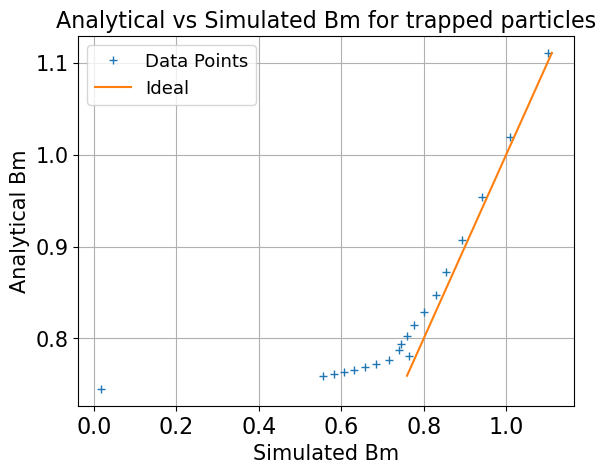

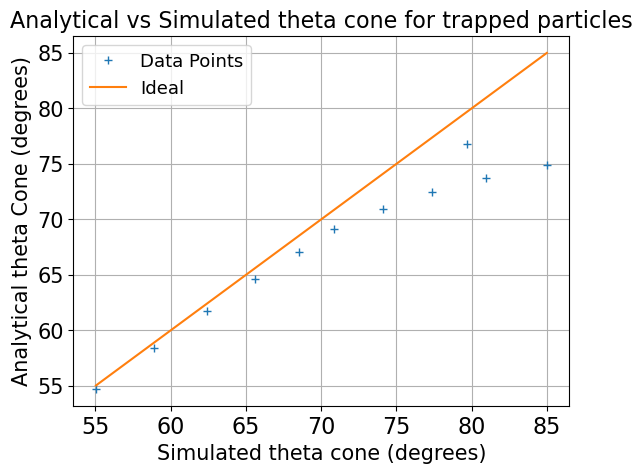

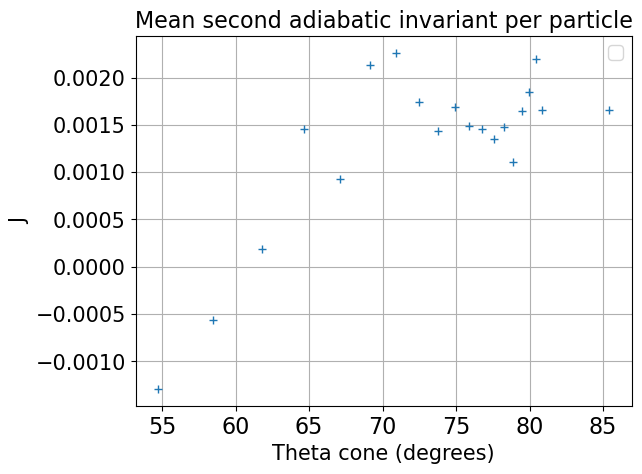

In [ ]:
plt.figure()
plt.plot(theta_cone*180/np.pi,t_trapped_list,"+")
# plt.plot(theta_cone_simu*180/np.pi,t_trapped_list,"o")
# plt.plot(np.array(mean_cone)*180/np.pi,mean_trapped,"o-",color='red',label='Averaged over 20 points')
# plt.fill_between(np.array(mean_cone)*180/np.pi, np.array(mean_trapped)-np.array(std_trapped), np.array(mean_trapped)+np.array(std_trapped), color='red', alpha=0.2, label='Std Dev')
# plt.legend()

# ind=np.argmin(np.abs(np.sort(np.array(mean_cone))*180/np.pi-20))
plt.xlabel("Theta Cone (degrees)")
plt.ylabel("Trapped Time (steps)")
plt.title("Trapped Time vs Theta Cone")
plt.grid()
# plt.xlim(None,20)

#bounce number
trapped_part_indexes=np.where(bounces_number>3)[0]
trapped_bounces_number=bounces_number[trapped_part_indexes]
coefs=np.polyfit(theta_cone[trapped_part_indexes]*180/np.pi,np.log(trapped_bounces_number),1)

plt.figure()
plt.plot(theta_cone*180/np.pi,bounces_number,"+",label="Data")
plt.plot(theta_cone[trapped_part_indexes]*180/np.pi,np.exp(coefs[0]*theta_cone[trapped_part_indexes]*180/np.pi+coefs[1]),"-",label=f"Linear fit of log {coefs[0]:.1f}*x+{coefs[1]:.1f}")
plt.xlabel("Theta Cone (degrees)")
plt.ylabel("Number of bounce")
plt.title("Trapped Time vs number of bounce")
plt.grid()
# plt.yscale('log')
plt.legend()


plt.figure()
plt.plot(Bm_list,Bm_ana,"+",label='Data Points')
plt.plot(Bm_ana,Bm_ana,"-",label='Ideal')
plt.ylabel("Analytical Bm")
plt.xlabel("Simulated Bm")
plt.title("Analytical vs Simulated Bm for trapped particles")
plt.grid()
plt.legend()

plt.figure()
plt.plot(theta_cone_simu*180/np.pi,theta_cone*180/np.pi,"+",label='Data Points')
plt.plot(theta_cone_simu*180/np.pi,theta_cone_simu*180/np.pi,"-",label='Ideal')
plt.ylabel("Analytical theta Cone (degrees)")
plt.xlabel("Simulated theta cone (degrees)")
plt.title("Analytical vs Simulated theta cone for trapped particles")
plt.grid()
plt.legend()

plt.figure()
plt.plot(theta_cone*180/np.pi,J_mean,"+")
plt.xlabel("Theta cone (degrees)")
plt.ylabel("J")
plt.title('Mean second adiabatic invariant per particle')
plt.grid()
plt.legend()


plt.show()
